In [4]:
# IO
import os

# Data
import numpy as np
import xarray as xr

# Plotting
import matplotlib.pyplot as plt
import cmcrameri  # nice colormaps

In [5]:
from thesis.io import fgong
from thesis.physics import first_adiabatic_exponent, sound_speed, acoustic_depth
from thesis.calculus import differentiate

In [6]:
# root_path = "/Users/ajl573/OneDrive/Data/MESA/solar_models"
root_path = os.path.expanduser("~/OneDrive/Data/MESA/solar_models/")
profile_name = "profile"

In [7]:
Ys = [0.26, 0.28, 0.3]

In [10]:
from cycler import cycler

In [8]:
models = {}
for Y in Ys:
    key = f"y{Y:.2f}"
    filename = os.path.join(root_path, key, ".".join([profile_name, "data", "FGONG"]))
    model = fgong.load_fgong(filename)
    model["cs"] = sound_speed(model.Gamma_1, model.P, model.rho)
    model["tau"] = acoustic_depth(model.r, model.cs, axis=0)
    models[Y] = model

In [24]:
custom_cycler = plt.rcParams['axes.prop_cycle'][:4] + cycler(ls=['-', '--', '-.', ':'])

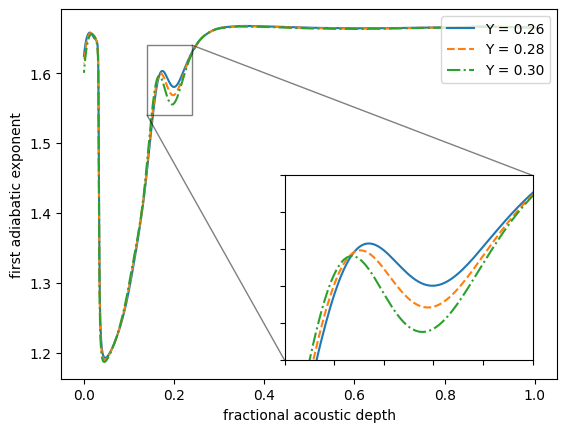

In [60]:
fig, ax = plt.subplots()

axin = ax.inset_axes([0.45, 0.05, 0.5, 0.5])
xin = (0.14, 0.24)
yin = (1.54, 1.64)

ax.set_prop_cycle(custom_cycler)
axin.set_prop_cycle(custom_cycler)

for Y in Ys:
    tau0 = models[Y].tau.max()
    xy = (models[Y].tau/tau0, models[Y].Gamma_1)
    ax.plot(*xy, label=f"Y = {Y:.2f}")
    axin.plot(*xy)
    
ax.set_xlabel("fractional acoustic depth")
ax.set_ylabel("first adiabatic exponent")
ax.legend(loc='upper right')

axin.set_xlim(xin)
axin.set_ylim(yin)
axin.set_xticklabels([])
axin.set_yticklabels([])

ax.indicate_inset_zoom(axin, edgecolor="black");

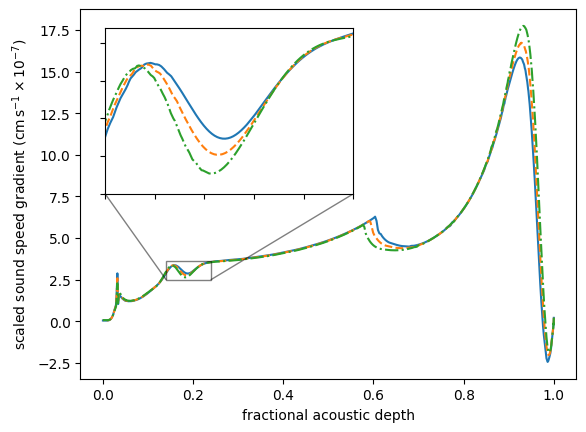

In [71]:
fig, ax = plt.subplots()

fac = -7

axin = ax.inset_axes([0.05, 0.5, 0.5, 0.45], )
xin = (0.14, 0.24)
yin = (10**fac*2.5e7, 10**fac*3.6e7)

ax.set_prop_cycle(custom_cycler)
axin.set_prop_cycle(custom_cycler)

for Y in Ys:
    tau0 = models[Y].tau.max()
    xy = (models[Y].tau/tau0, 10**fac*tau0*differentiate(models[Y].cs, models[Y].tau))
    ax.plot(*xy, label=f"Y = {Y:.2f}")
    axin.plot(*xy)

ax.set_xlabel("fractional acoustic depth")
ax.set_ylabel(r"sound speed gradient ($\mathrm{cm\,s^{-1}}\times 10^{" + f"{fac}" + "}$)")

axin.set_xlim(xin)
axin.set_ylim(yin)
axin.set_xticklabels([])
axin.set_yticklabels([])

ax.indicate_inset_zoom(axin, edgecolor="black");
# ax.legend()